In [ ]:

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/IDA.zip" /content/

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/loadbm.py" /content/

In [ ]:
%%capture
!unzip IDA.zip

In [ ]:
!rm IDA.zip

In [ ]:
import numpy as np
import os
import ntpath
import platform
import matplotlib.pyplot as plt
from loadbm import create_df, create_tf_dataset, prepare_for_training


datapath = 'IDA/Separate lists with numbering/Machine learning splits'
img_path = 'IDA/Images/'

split = 1

train_fname = 'train'+str(split)+'.txt'
test_fname = 'test'+str(split)+'.txt'
val_fname = 'val'+str(split)+'.txt'

part_dat = False

df_train = create_df(os.path.join(datapath, train_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_test = create_df(os.path.join(datapath, test_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_val = create_df(os.path.join(datapath, val_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_val = shuffle(df_val)

df_train.head()

,path,label
155594,IDA/Images/Lepidostoma_hir266/1-Lepidostoma_hi...,18
21243,IDA/Images/Amphinemura_bor290/0-Amphinemura_bo...,3
312548,IDA/Images/Taeniopteryx_neb156/1-Taeniopteryx_...,39
3498,IDA/Images/Agapetus197/1-Agapetus197.1.2016-10...,1
202763,IDA/Images/Micrasema_gel91/1-Micrasema_gel91.1...,23


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMSIZE = (224,224,3)
BATCH_SIZE = 32

train_ds = create_tf_dataset(df_train, imsize=IMSIZE, onehot=True)

val_ds = create_tf_dataset(df_val, imsize=IMSIZE, onehot=True)


train_ds = prepare_for_training(train_ds, 
                                shuffle_buffer_size=1000,
                                batch_size=BATCH_SIZE)

val_ds = prepare_for_training(val_ds, 
                              shuffle_buffer_size=1000,
                              batch_size=BATCH_SIZE)

for image, label in train_ds.take(5):
    print(image.shape)
    print(label.shape)


(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)


<BarContainer object of 39 artists>

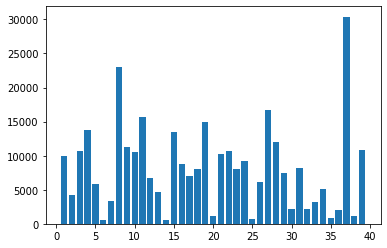

In [ ]:
import tensorflow.keras.backend as K

def class_balanced_loss(y_n):

    N = np.max(y_n)
    beta = (N-1)/N 

    beta = K.cast(beta, tf.float32)

    y_n = K.cast(y_n, tf.float32)
    E = (1- K.pow(beta, y_n))/(1-beta)

    alpha = (1/E)

    def loss(y,yhat):
        
      y = K.cast(y, tf.float32)
      yhat = tf.convert_to_tensor(yhat, dtype=y.dtype)
      
      CB = -K.sum( y*K.log(yhat + K.epsilon())*alpha, axis=1 )
      
      return CB

    return loss

y_n = np.ravel(df_train.groupby('label').count().values)
plt.bar(range(1,40), y_n)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


def get_pretrained(imsize=(224, 224, 3), classes=39):
        base_model = InceptionV3(input_shape = imsize, 
                                 weights='imagenet', 
                                 include_top=False)
        
        base_model.trainable = True
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

model = get_pretrained()

loss = class_balanced_loss(y_n) 

model.compile(optimizer = 'adam', loss = loss,
                  metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime


tr_steps = len(df_train)//BATCH_SIZE
val_steps = len(df_val)//BATCH_SIZE

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 10,
          validation_steps = val_steps)


Train for 10043 steps, validate for 1434 steps
Epoch 1/10
10043/10043 [==============================] - 1631s 162ms/step - loss: 8.8514e-05 - accuracy: 0.7949 - val_loss: 1.8109e-04 - val_accuracy: 0.7105
Epoch 2/10
10043/10043 [==============================] - 1621s 161ms/step - loss: 2.1156e-05 - accuracy: 0.9481 - val_loss: 1.2784e-04 - val_accuracy: 0.8407
Epoch 3/10
10043/10043 [==============================] - 1622s 162ms/step - loss: 1.0616e-05 - accuracy: 0.9735 - val_loss: 1.5391e-04 - val_accuracy: 0.8302
Epoch 4/10
10043/10043 [==============================] - 1621s 161ms/step - loss: 6.7199e-06 - accuracy: 0.9829 - val_loss: 1.2125e-04 - val_accuracy: 0.8963
Epoch 5/10
10043/10043 [==============================] - 1616s 161ms/step - loss: 6.3566e-06 - accuracy: 0.9852 - val_loss: 1.3542e-04 - val_accuracy: 0.8860
Epoch 6/10
10043/10043 [==============================] - 1617s 161ms/step - loss: 4.9287e-06 - accuracy: 0.9884 - val_loss: 1.4841e-04 - val_accuracy: 0.8968

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001) #original 0.001

from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    return 0.0001 * tf.math.exp(0.1 * (-epoch))

lr_cb = LearningRateScheduler(scheduler)

model.compile(optimizer = adam, loss = loss,
                  metrics=['accuracy'])

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 5,
          validation_steps = val_steps,
          callbacks=[lr_cb])

Train for 10043 steps, validate for 1434 steps
Epoch 1/5
10043/10043 [==============================] - 1627s 162ms/step - loss: 3.3740e-07 - accuracy: 0.9990 - val_loss: 1.2770e-04 - val_accuracy: 0.9144
Epoch 2/5
10043/10043 [==============================] - 1622s 161ms/step - loss: 1.0637e-07 - accuracy: 0.9997 - val_loss: 1.2777e-04 - val_accuracy: 0.9154
Epoch 3/5
10043/10043 [==============================] - 1619s 161ms/step - loss: 7.8838e-08 - accuracy: 0.9998 - val_loss: 1.3408e-04 - val_accuracy: 0.9142
Epoch 4/5
10043/10043 [==============================] - 1619s 161ms/step - loss: 7.1805e-08 - accuracy: 0.9998 - val_loss: 1.3013e-04 - val_accuracy: 0.9171
Epoch 5/5
10043/10043 [==============================] - 1619s 161ms/step - loss: 6.3781e-08 - accuracy: 0.9998 - val_loss: 1.3251e-04 - val_accuracy: 0.9182


In [ ]:
model.history.history

{'accuracy': [0.99903226, 0.99972, 0.9997604, 0.9997915, 0.9998382],
 'loss': [3.3739844663646084e-07,
  1.0637463786288528e-07,
  7.883755150505403e-08,
  7.180513308653064e-08,
  6.378132080930802e-08],
 'lr': [1e-04, 9.0483736e-05, 8.187308e-05, 7.4081814e-05, 6.7032e-05],
 'val_accuracy': [0.9144003, 0.91538095, 0.91418236, 0.9170807, 0.9182139],
 'val_loss': [0.00012769819607449056,
  0.0001277652356903626,
  0.00013408201317137284,
  0.00013013335263136556,
  0.0001325114531368045]}

In [ ]:
model.save('36-xx-2020.h5')

In [ ]:
!cp '36-xx-2020.h5' "/content/drive/My Drive/koulu_honmia/kandi19/"

Evaluation:

In [ ]:
test_ds = create_tf_dataset(df_test, imsize=IMSIZE, onehot=True)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/combine_insects.py" /content/

In [ ]:
preds = model.predict(test_ds, verbose=True)
yhat = np.argmax(preds,axis=1)+1
y_test = df_test['label']

acc = np.sum(yhat==y_test)/len(y_test)
print('Image accuracy: {:.4f}'.format(acc))

np.save('36-xx-2020.npy', preds)

2897/2897 [==============================] - 156s 54ms/step
Image accuracy: 0.9191


In [ ]:
!cp '36-xx-2020.npy' "/content/drive/My Drive/koulu_honmia/kandi19/"

In [ ]:
#%% Insect combine
from combine_insects import add_insect_class, add_yhat

df_test_preds = add_insect_class(df_test)

# adding predictions to dataframe for insect-wise prediction
df_test_preds = add_yhat(df_test_preds,yhat)

dfg = df_test_preds.groupby(['label','insect'],as_index=False)['pred'].agg(lambda x:x.value_counts().index[0])

acc_g = np.sum(dfg['pred']==dfg['label'])/len(dfg)
print('Aggregate accuracy: {:.4f}'.format(acc_g))

Aggregate accuracy: 0.9549


In [ ]:
model.history.history

{'accuracy': [0.99903226, 0.99972, 0.9997604, 0.9997915, 0.9998382],
 'loss': [3.3739844663646084e-07,
  1.0637463786288528e-07,
  7.883755150505403e-08,
  7.180513308653064e-08,
  6.378132080930802e-08],
 'lr': [1e-04, 9.0483736e-05, 8.187308e-05, 7.4081814e-05, 6.7032e-05],
 'val_accuracy': [0.9144003, 0.91538095, 0.91418236, 0.9170807, 0.9182139],
 'val_loss': [0.00012769819607449056,
  0.0001277652356903626,
  0.00013408201317137284,
  0.00013013335263136556,
  0.0001325114531368045]}